# Problem Statement
To build a CNN-based model which can accurately detect melanoma.  
Melanoma is a type of cancer that can be deadly if not detected early, accounting for 75% of skin cancer deaths.  
A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

---

## Dataset Information
- The dataset consists of **2357 images** of malignant and benign oncological diseases.
- Images were collected from the **International Skin Imaging Collaboration (ISIC)**.
- All images were sorted and classified according to ISIC standards.
- Subsets were divided into equal numbers, except for melanomas and moles, which are slightly dominant.

---

## Diseases in the Dataset
1. Actinic keratosis  
2. Basal cell carcinoma  
3. Dermatofibroma  
4. Melanoma  
5. Nevus  
6. Pigmented benign keratosis  
7. Seborrheic keratosis  
8. Squamous cell carcinoma  
9. Vascular lesion  


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from collections import Counter
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from glob import glob
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import plot_model

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
abs_path_train = "/content/gdrive/My Drive/Colab Notebooks/Melanoma/Train";
abs_path_test = "/content/gdrive/My Drive/Colab Notebooks/Melanoma/Test";

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(abs_path_train)
data_dir_test = pathlib.Path(abs_path_test)
## data_dir_train = pathlib.Path("data/Train")
## data_dir_test = pathlib.Path('data/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,  # Same seed for consistent train-validation split
    validation_split=0.2,
    subset="validation"
)


Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

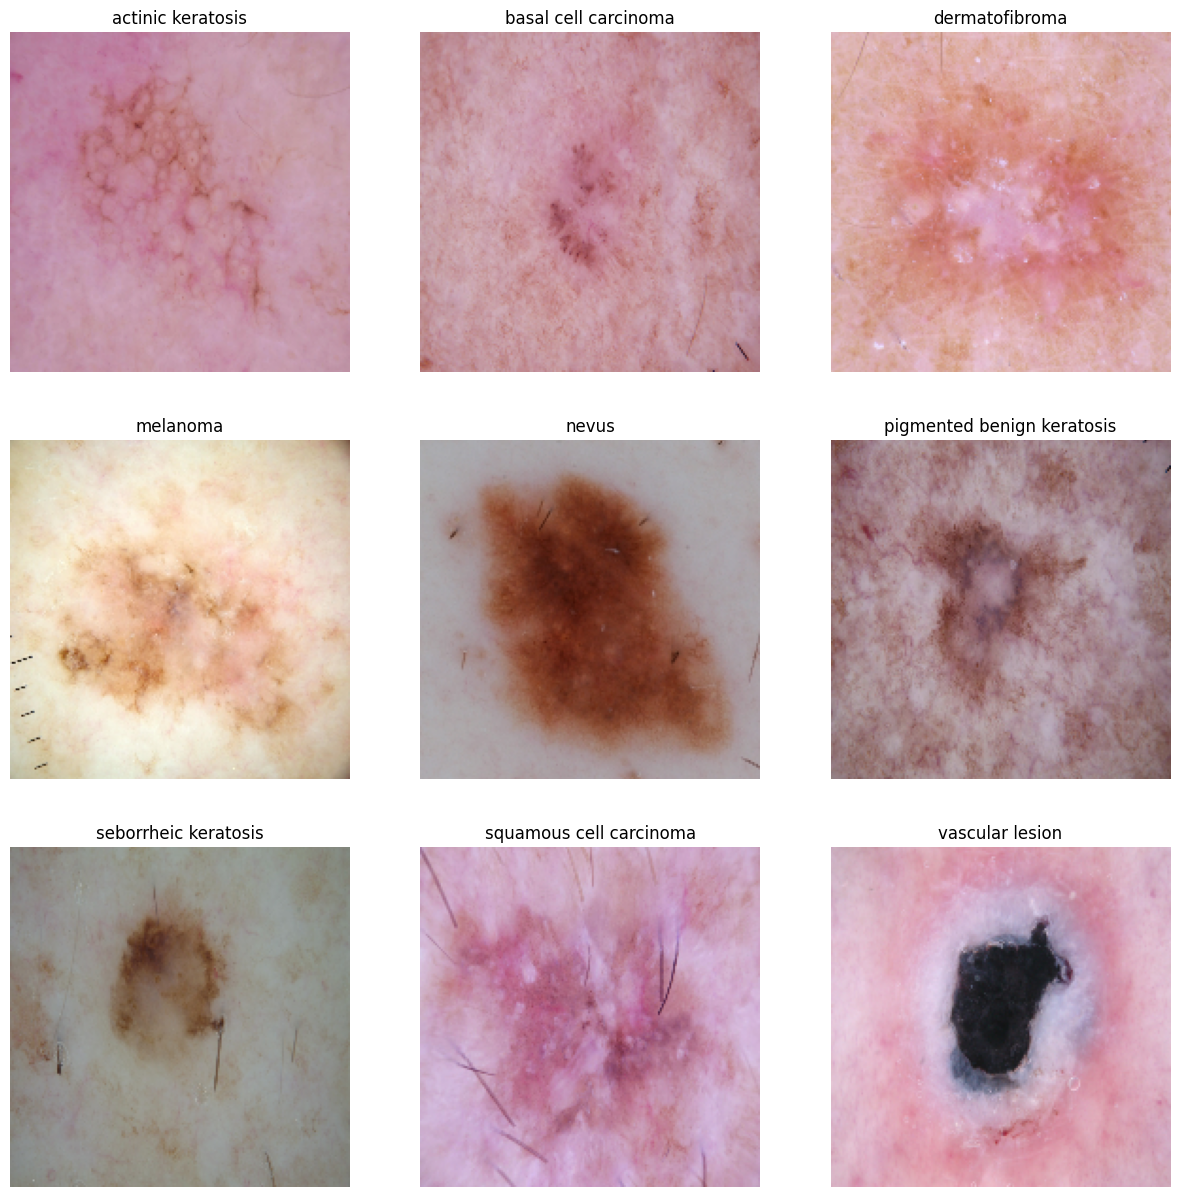

In [10]:
def visualize_samples(dataset, class_names):
    plt.figure(figsize=(15, 15))
    # Iterate through the batched dataset
    for i in range(len(class_names)):
        found = False
        for images, labels in dataset:  # Process batches
            for idx in range(len(labels)):  # Iterate within the batch
                if labels[idx].numpy() == i:  # Match the class index
                    ax = plt.subplot(3, 3, i + 1)
                    plt.imshow(images[idx].numpy().astype("uint8"))
                    plt.title(class_names[i])
                    plt.axis("off")
                    found = True
                    break
            if found:
                break
        else:
            print(f"No samples found for class: {class_names[i]}")
    plt.show()

# Call the function
visualize_samples(train_ds, class_names)


### Data Augmentation Visualization
#### To observe how augmented images look, apply augmentation techniques like rotation, zoom, and flipping and visualize the augmented images.

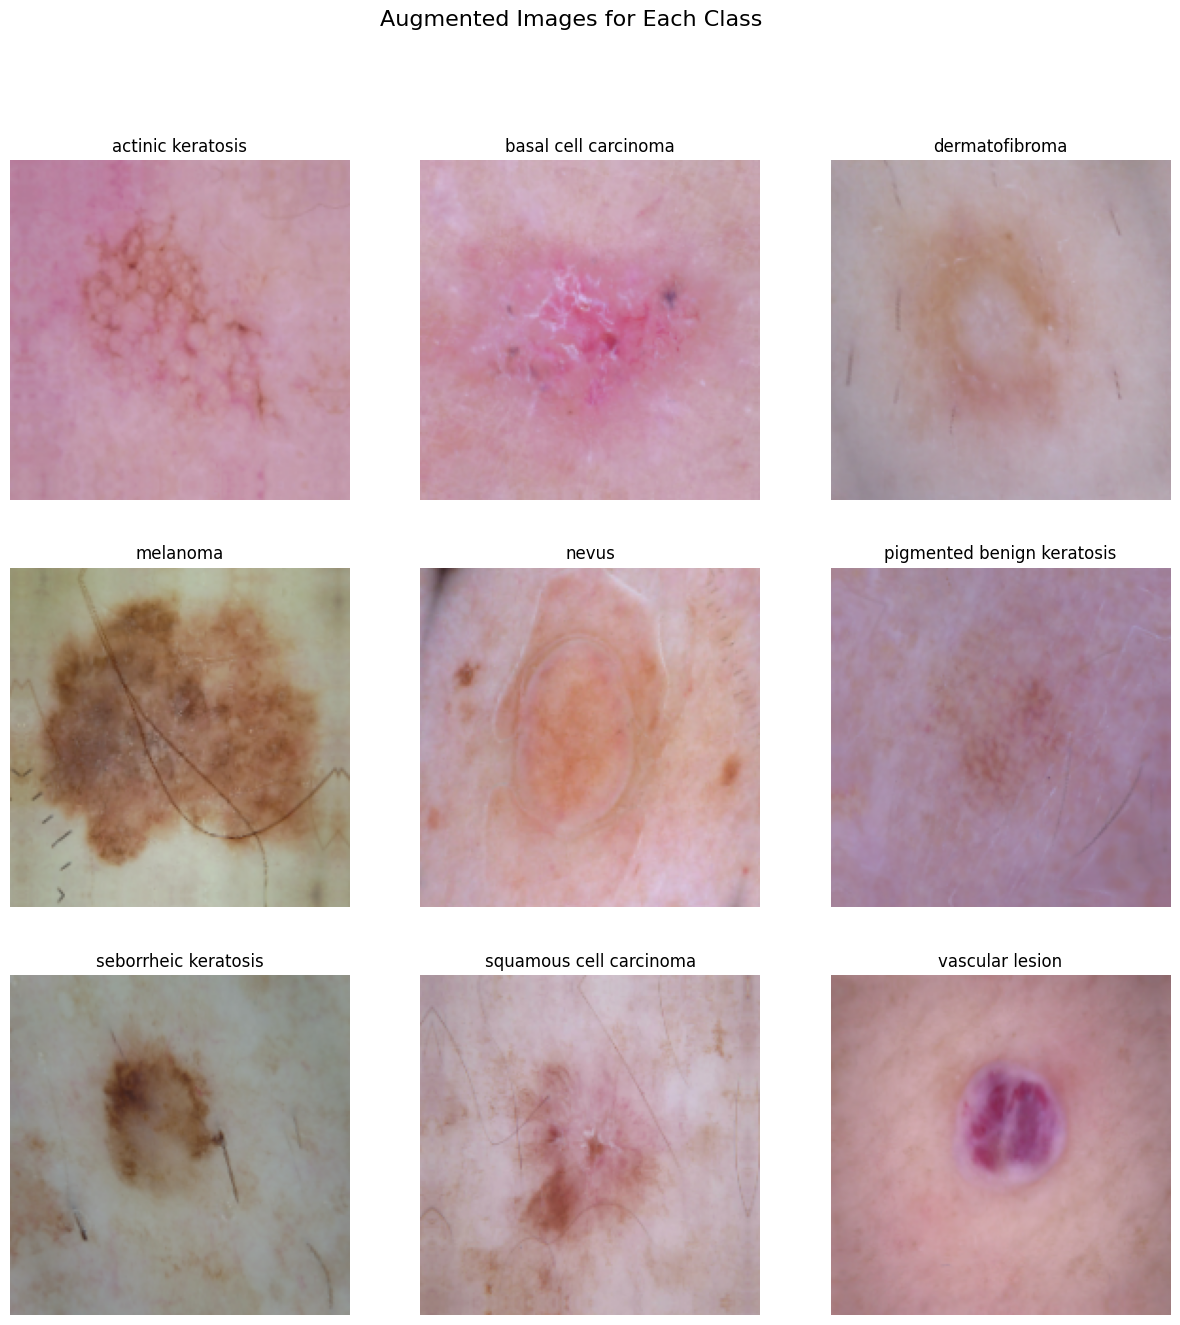

In [11]:
# Define an augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Function to display one augmented image per class
def visualize_one_augmented_image_per_class(dataset, class_names):
    plt.figure(figsize=(15, 15))

    # Store one image for each class
    class_images = {}

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        for idx in range(len(labels)):  # Iterate through each sample in the batch
            label_value = labels[idx].numpy()  # Convert label tensor to numpy
            if label_value not in class_images:
                class_images[label_value] = images[idx]  # Store the image for the class
            # Stop once we have one image for each class
            if len(class_images) == len(class_names):
                break
        if len(class_images) == len(class_names):
            break

    # Visualize augmented images for each class
    for class_index, class_name in enumerate(class_names):
        ax = plt.subplot(3, 3, class_index + 1)  # Create a 3x3 grid
        if class_index in class_images:
            # Apply data augmentation to the image
            augmented_image = data_augmentation(tf.expand_dims(class_images[class_index], axis=0))
            plt.imshow(augmented_image[0].numpy().astype("uint8"))
            plt.title(class_name)
        else:
            plt.title(f"No image for {class_name}")
        plt.axis("off")

    plt.suptitle("Augmented Images for Each Class", fontsize=16)
    plt.show()

# Call the function
visualize_one_augmented_image_per_class(train_ds, class_names)


### Class Distribution in split train data


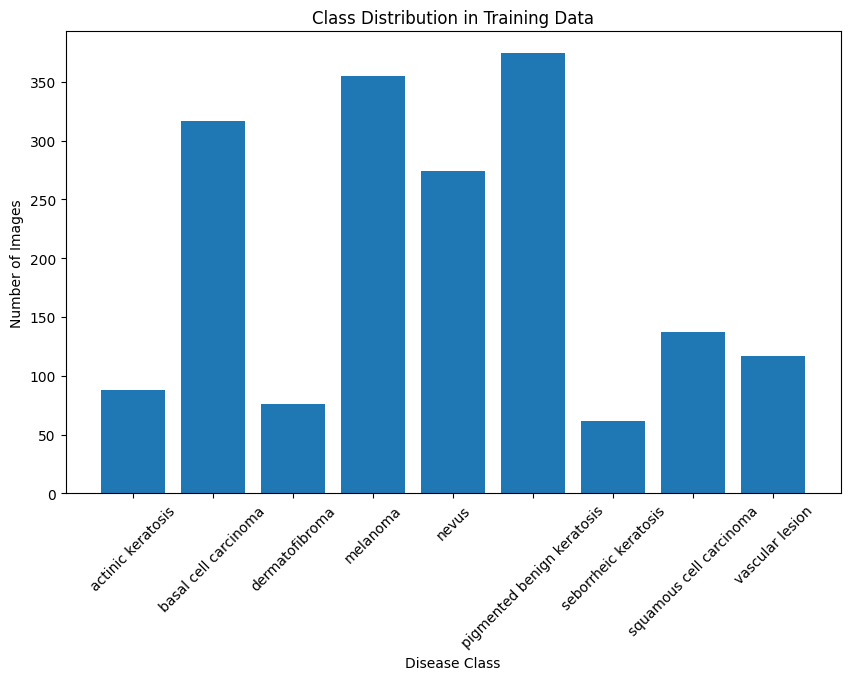

In [12]:
# Count the number of images per class in the training dataset
class_counts = Counter([label.numpy() for _, labels in train_ds for label in labels])

# Get class names from the dataset
class_names = train_ds.class_names

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, [class_counts[i] for i in range(len(class_names))])
plt.title("Class Distribution in Training Data")
plt.xlabel("Disease Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

In [13]:
class_counts_named = {class_names[index]: count for index, count in class_counts.items()}

print("Class Counts:")
for class_name, count in class_counts_named.items():
    print(f"{class_name}: {count}")

Class Counts:
dermatofibroma: 76
melanoma: 355
pigmented benign keratosis: 374
basal cell carcinoma: 317
nevus: 274
vascular lesion: 117
squamous cell carcinoma: 137
actinic keratosis: 88
seborrheic keratosis: 62


### Class Imbalance Analysis

### Observations

- Classes such as **Seborrheic keratosis** and **dermatofibroma** are significantly underrepresented.
- Classes like **Basal cell carcinoma** and **Pigmented benign keratosis** dominate the dataset.


### Image Size Distribution
#### If the dataset contains images of varying sizes, it’s useful to analyze the dimensions. This can guide decisions on resizing or padding.

In [14]:
# Gather image dimensions
image_shapes = [image.shape for image_batch, _ in train_ds for image in image_batch]
heights = [shape[0] for shape in image_shapes]
widths = [shape[1] for shape in image_shapes]

# Plot height and width distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(heights, bins=20)
plt.title("Height Distribution of Images")
plt.xlabel("Height")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(widths, bins=20)
plt.title("Width Distribution of Images")
plt.xlabel("Width")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Pixel Intensity Distribution
#### Visualizing pixel intensity distribution helps determine if normalization is required. This can be useful for color images (RGB channels) to understand how bright or dark the images are overall.

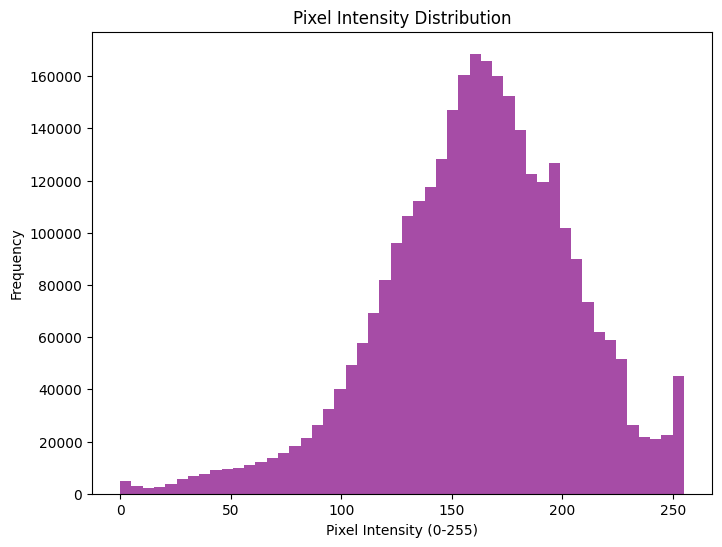

In [15]:
# Collect pixel values
pixel_values = []
for images, _ in train_ds.take(1):  # Take one batch of images
    pixel_values.extend(images.numpy().ravel())

# Plot pixel intensity distribution
plt.figure(figsize=(8, 6))
plt.hist(pixel_values, bins=50, color="purple", alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.show()


The pixel intensity values range from approximately 0 to 255, which is typical for RGB images where each pixel’s intensity value can vary within this range.

The dataset has relatively bright images with most pixel values around the mid-to-high intensity range. Normalization of these values before feeding them into a neural network is recommended to ensure consistency and enhance model learning. This information can guide you in choosing appropriate preprocessing and augmentation strategies, such as brightness adjustment or normalization, to optimize the dataset for training.

Statistical Summary of Class Counts:

In [16]:
class_counts_list = [class_counts[i] for i in range(len(train_ds.class_names))]
print("Class Counts:", class_counts_list)
print("Mean:", np.mean(class_counts_list))
print("Median:", np.median(class_counts_list))
print("Standard Deviation:", np.std(class_counts_list))


Class Counts: [88, 317, 76, 355, 274, 374, 62, 137, 117]
Mean: 200.0
Median: 137.0
Standard Deviation: 120.77895328059253


### Class Imbalance Analysis

Yes, the dataset exhibits **class imbalance**, as some classes have significantly fewer samples than others.

This imbalance can have the following negative impacts:
- The model might **struggle to learn meaningful patterns** for underrepresented classes.
- It could lead to **biased predictions**, where the model favors the overrepresented classes, reducing overall performance.

Addressing this imbalance is crucial to ensure the model performs well across all classes.


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the Model 1
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
# Build the CNN model

model = models.Sequential(name="Model_1", layers= [

    # Input layer with Rescaling to normalize pixel values
    layers.Input(shape=(img_height, img_width, 3)),  # (height, width, RGB channels)
    layers.Rescaling(1./255),  # Normalizing pixel values to [0, 1]

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flattening layer to prepare for dense layers
    layers.Flatten(),

    # Fully Connected Dense Layer
    layers.Dense(128, activation='relu'),

    # Output Layer with softmax activation for multiclass classification
    layers.Dense(len(class_names), activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [19]:
### compile model with optimiser and loss function
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Using sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

In [20]:
# View the summary of all layers
model.summary()

Model: "Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Plot the Model Architecture
plot_model(
    model,
    to_file='model_1.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=100
)

### Train the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 760ms/step - accuracy: 0.2130 - loss: 2.6514 - val_accuracy: 0.3051 - val_loss: 1.9501
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3358 - loss: 1.8468 - val_accuracy: 0.4076 - val_loss: 1.5941
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4708 - loss: 1.4982 - val_accuracy: 0.4699 - val_loss: 1.4303
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5181 - loss: 1.4208 - val_accuracy: 0.4744 - val_loss: 1.3841
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5618 - loss: 1.2582 - val_accuracy: 0.5145 - val_loss: 1.3080
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5700 - loss: 1.2388 - val_accuracy: 0.4922 - val_loss: 1.4312
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5828 - loss: 1.1841 - val_accuracy: 0.5122 - val_loss: 1.3482
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6109 - loss: 1.0774 - val_accuracy: 0.4900 -

### Visualizing training results

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations

#### Training Accuracy
- The training accuracy improves consistently and reaches a high value (~0.9) after several epochs.
- This indicates that the model is learning the training data well.

#### Validation Accuracy
- The validation accuracy does not follow the same trend as the training accuracy and fluctuates around ~0.5 to ~0.6.
- This gap between training and validation accuracy indicates **overfitting**:
  - The model is performing well on the training set but fails to generalize on unseen data.

#### Training Loss
- The training loss decreases steadily over epochs, showing that the model is minimizing the error on the training data.

#### Validation Loss
- The validation loss decreases initially but starts to increase after a few epochs (~5-6 epochs).
- This indicates that the model is starting to **overfit**.


### Data Augmentation Strategy

To combat overfitting, we can introduce data augmentation. The goal is to make the model more robust by artificially increasing the variability of the training data. Below is the strategy to apply:

Data Augmentation Layers
- Random Flip: Randomly flip images horizontally.
- Random Rotation: Rotate images randomly by up to 20%.
- Random Zoom: Randomly zoom into images to simulate different distances.
- Random Contrast: Randomly adjust image contrast.

### Data Augmentation Visualization

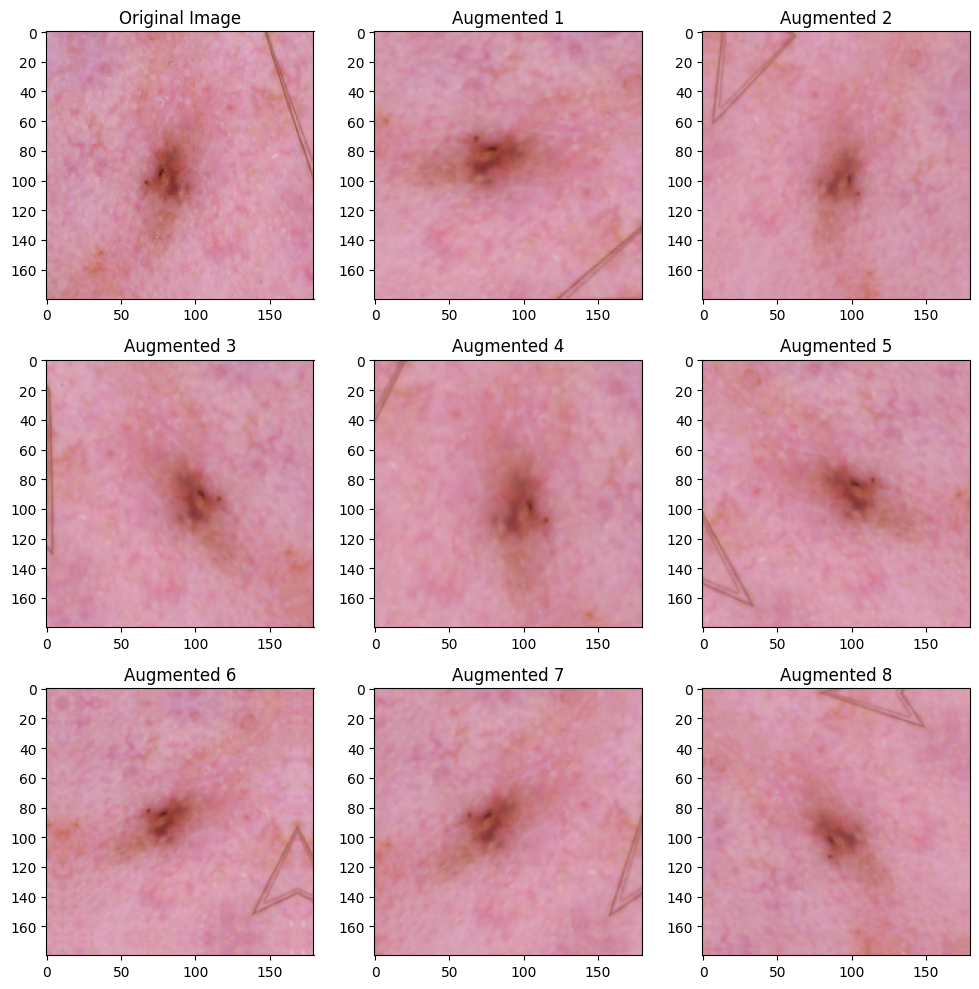

In [24]:
# Define the data augmentation strategy
data_augmentation =  models.Sequential([
    layers.RandomFlip("horizontal"),  # Random horizontal flip
    layers.RandomRotation(0.2),       # Random rotation (20%)
    layers.RandomZoom(0.2),           # Random zoom
    layers.RandomContrast(0.2)        # Random contrast adjustment
])

# Load one image from the training dataset
for images, _ in train_ds.take(1):  # Take one batch of training images
    sample_image = images[0]  # Take the first image from the batch
    break

# Plot original and augmented versions of the image
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(3, 3, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original Image")

# Augmented images
for i in range(8):
    augmented_image = data_augmentation(tf.expand_dims(sample_image, axis=0))  # Apply augmentation
    plt.subplot(3, 3, i + 2)
    plt.imshow(tf.squeeze(augmented_image).numpy().astype("uint8"))  # Squeeze and convert to uint8
    plt.title(f"Augmented {i + 1}")

plt.tight_layout()
plt.show()


### Create a Model with Data Augmentation Strategy

In [25]:
# Build the CNN model

model = models.Sequential([

    # Input layer with Rescaling to normalize pixel values
    layers.Input(shape=(img_height, img_width, 3)),  # (height, width, RGB channels)
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.Rescaling(1./255),  # Normalizing pixel values to [0, 1]

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flattening layer to prepare for dense layers
    layers.Flatten(),

    # Fully Connected Dense Layer
    layers.Dense(128, activation='relu'),

    # Output Layer with softmax activation for multiclass classification
    layers.Dense(len(class_names), activation='softmax')
])

### Compiling the model

In [26]:
### compile model with optimiser and loss function
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Using sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

In [27]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_2 (RandomZoom)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

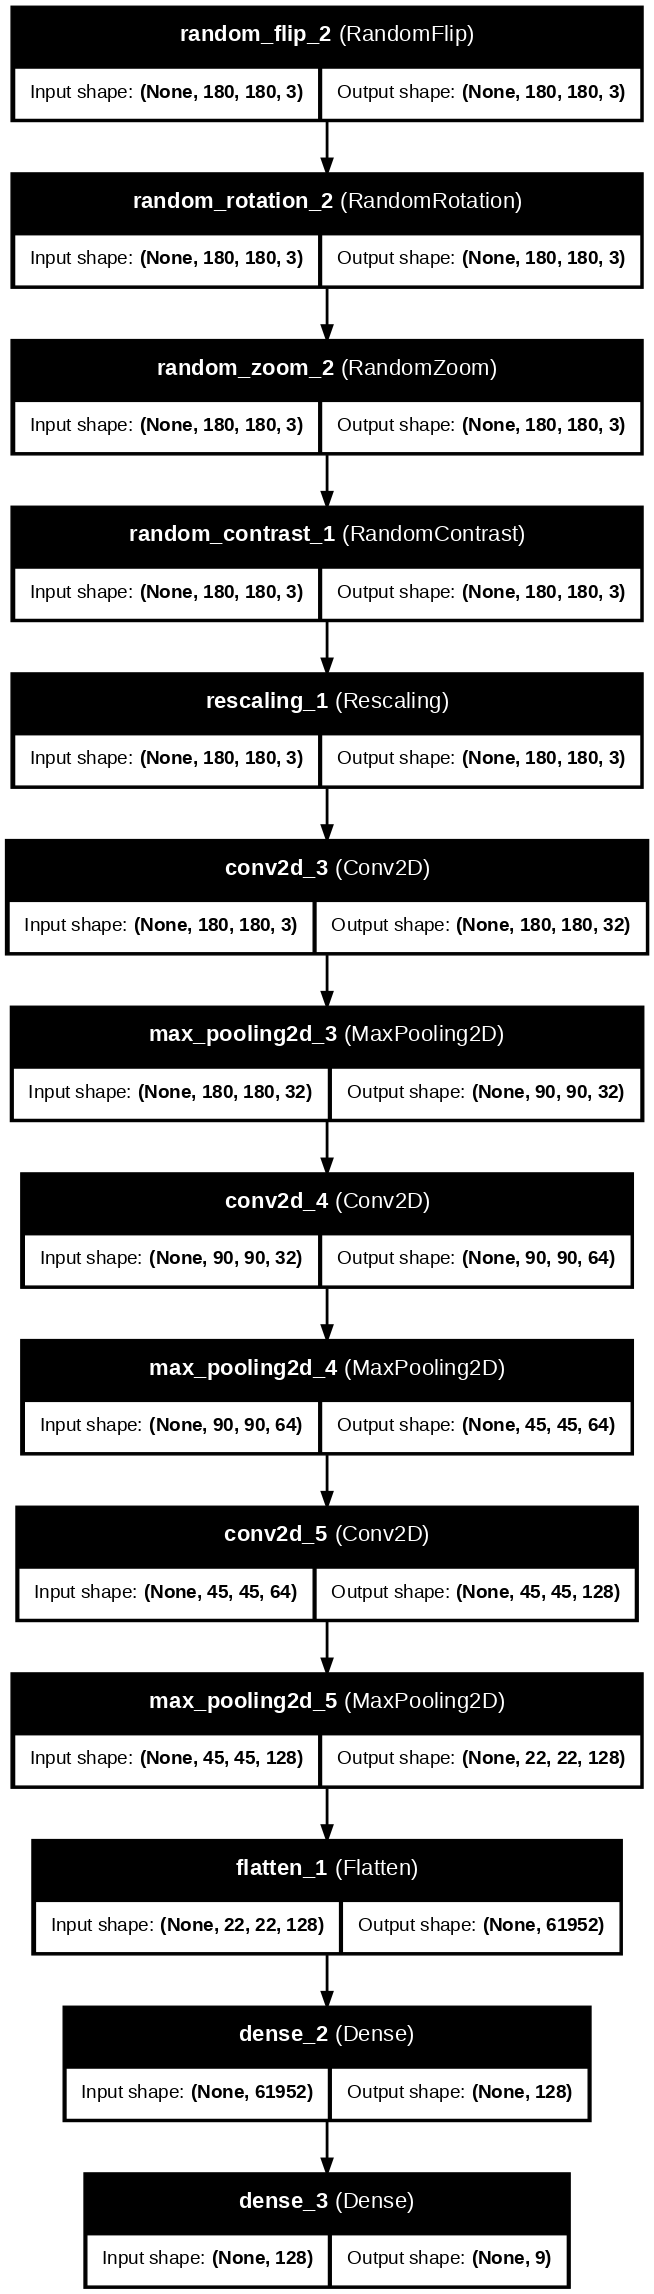

In [28]:
# Plot the Model Architecture
plot_model(
    model,
    to_file='model_data_augmented.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=100
)

### Training the model

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.2030 - loss: 2.4649 - val_accuracy: 0.3118 - val_loss: 1.8479
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3500 - loss: 1.8186 - val_accuracy: 0.3474 - val_loss: 1.8185
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4031 - loss: 1.6395 - val_accuracy: 0.4388 - val_loss: 1.5877
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4842 - loss: 1.5201 - val_accuracy: 0.4499 - val_loss: 1.4088
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4951 - loss: 1.4238 - val_accuracy: 0.4855 - val_loss: 1.3764
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5143 - loss: 1.3820 - val_accuracy: 0.4900 - val_loss: 1.3571
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5317 - loss: 1.3070 - val_accuracy: 0.4967 - val_loss: 1.3608
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5195 - loss: 1.3383 - val_accuracy: 0.4989 - v

### Visualizing the results

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations - Model with Data Augmentation Strategy

#### Low Accuracy
- Both training and validation accuracy are low, indicating the model is not learning patterns effectively.
- A training accuracy suggests the model is **underfitting**, as it struggles to fit the training data adequately.

#### Close Training and Validation Metrics
- The closeness of training and validation accuracy and loss  suggests the model is **not overfitting**.
- Instead, it is performing similarly poorly on both the training and validation datasets, a hallmark of **underfitting**.

#### High Loss Values
- Both training and validation losses remain high, further indicating that the model is not capturing complex patterns in the data.

---
#### Conclusion
- The model is **underfitting**.
- It is not learning the training data effectively, resulting in **low accuracy** and **high loss** for both training and validation datasets.


### Adding Additional dropout layer after dense layer

### Create the Model

In [31]:
## using more Dropout layer

# Build the updated CNN model
model = models.Sequential([
    # Input Layer (Normalization)
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),  # Use Rescaling directly with input shape

    # First Convolutional Block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Dropout layer after third block
    layers.Dropout(0.5),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Dense Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Additional dropout layer after dense layer

    # Output Layer
    layers.Dense(len(class_names), activation='softmax')  # Multiclass classification
])




### Compiling the model

In [32]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Using sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

In [33]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Plot the Model Architecture
plot_model(
    model,
    to_file='model_extra_droput_layer.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=100
)

In [35]:
epochs = 20

### Training the model

In [36]:
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs,  # Set the number of epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.1985 - loss: 2.2837 - val_accuracy: 0.2405 - val_loss: 2.0087
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2334 - loss: 2.0013 - val_accuracy: 0.3163 - val_loss: 1.8499
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3318 - loss: 1.8507 - val_accuracy: 0.3318 - val_loss: 1.7887
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3442 - loss: 1.7904 - val_accuracy: 0.3430 - val_loss: 1.7720
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3915 - loss: 1.7226 - val_accuracy: 0.4232 - val_loss: 1.6163
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3970 - loss: 1.6653 - val_accuracy: 0.4254 - val_loss: 1.5969
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4182 - loss: 1.6288 - val_accuracy: 0.3853 - val_loss: 1.7053
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4547 - loss: 1.5525 - val_accuracy: 0.4633 -

### Visualizing the results

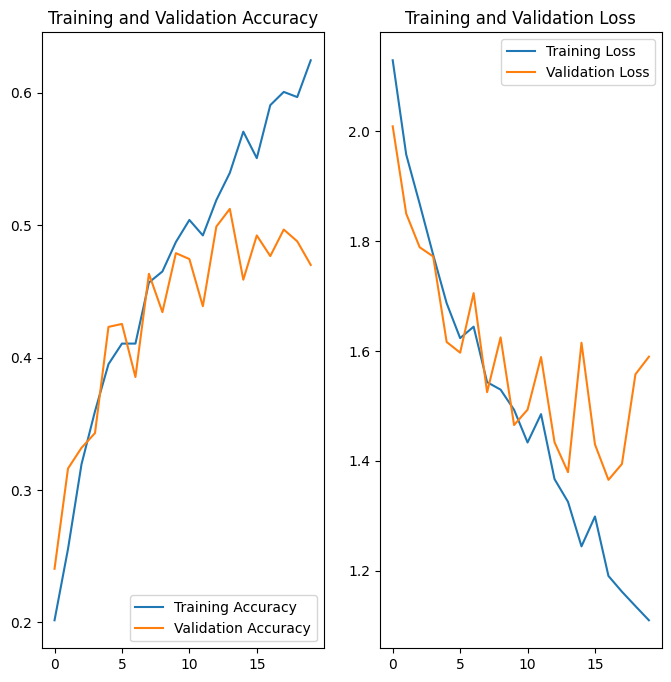

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation of Overfitting/Underfitting
- No Overfitting: The validation accuracy is slightly better than training accuracy, and the validation loss aligns with the training loss.
- Possible Underfitting: The model has room for improvement in learning more complex features.


#### **Class Distribution:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
# Plot class distribution

import seaborn as sns

# Create a DataFrame from the dictionary for seaborn
import pandas as pd
data = pd.DataFrame({
    'Disease Class': list(class_counts_named.keys()),
    'Number of Images': list(class_counts_named.values())
})

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Disease Class', y='Number of Images', data=data, palette='viridis')
plt.title("Class Distribution in Training Data", fontsize=16)
plt.xlabel("Disease Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better visibility
plt.tight_layout()
plt.show()


<ipython-input-38-32115ba7f6d1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Disease Class', y='Number of Images', data=data, palette='viridis')


In [39]:
class_counts_named = {class_names[index]: count for index, count in class_counts.items()}

print("Class Counts:")
for class_name, count in class_counts_named.items():
    print(f"{class_name}: {count}")

Class Counts:
dermatofibroma: 76
melanoma: 355
pigmented benign keratosis: 374
basal cell carcinoma: 317
nevus: 274
vascular lesion: 117
squamous cell carcinoma: 137
actinic keratosis: 88
seborrheic keratosis: 62


#### Which class has the least number of samples?
- The class `seborrheic keratosis:` has the least number of samples.
#### Which classes dominate the data in terms proportionate number of samples?

- Melanoma
- pigmented benign keratosis
- basal cell carcinoma



#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [40]:
 !pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
import Augmentor

In [42]:
def do_augmentor(class_names, path_train):
    path_to_training_dataset = path_train + "/"
    for i in class_names:
        p = Augmentor.Pipeline(path_to_training_dataset + i)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


In [43]:
do_augmentor(class_names, abs_path_train);

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1250104460>: 100%|██████████| 500/500 [00:04<00:00, 101.37 Samples/s]


Initialised with 386 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E123FFF0A00>: 100%|██████████| 500/500 [00:04<00:00, 102.46 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1146F7F430>: 100%|██████████| 500/500 [00:05<00:00, 97.53 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E1146F3A0B0>: 100%|██████████| 500/500 [00:17<00:00, 28.64 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7E11B7E21B70>: 100%|██████████| 500/500 [00:18<00:00, 27.01 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E11B79CB9A0>: 100%|██████████| 500/500 [00:05<00:00, 97.40 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E11B7E21F30>: 100%|██████████| 500/500 [00:09<00:00, 54.79 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E11B7E94FA0>: 100%|██████████| 500/500 [00:04<00:00, 101.23 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E11B7E21B70>: 100%|██████████| 500/500 [00:04<00:00, 100.85 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [47]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [48]:
df['Label'].value_counts()

Label
basal cell carcinoma          500
vascular lesion               500
actinic keratosis             500
nevus                         500
melanoma                      500
seborrheic keratosis          500
pigmented benign keratosis    500
dermatofibroma                500
squamous cell carcinoma       500
Name: count, dtype: int64

#### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [51]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### Create a validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### Model with normalization

In [53]:
# Build the updated CNN model
model = models.Sequential([
    # Input Layer (Normalization)
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),  # Normalize pixel values to [0, 1]

    # First Convolutional Block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),  # Add BatchNormalization
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),  # Add BatchNormalization
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),  # Add BatchNormalization
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Dropout layer after the third block
    layers.Dropout(0.5),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Dense Layer
    layers.Dense(128, activation='relu'),

    # Output Layer
    layers.Dense(len(class_names), activation='softmax')  # Multiclass classification
])

####  Compile model (Adding optimizer and loss function)

In [54]:
# Compile the Model

## sparse_categorical_crossentropy
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy loss for int labels
    metrics=['accuracy']
)

In [55]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,649,033 (25.36 MB)

 Trainable params: 6,648,585 (25.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [56]:
# Plot the Model Architecture
plot_model(
    model,
    to_file='model_augmentor_bn.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=100
)

#### Train model

In [57]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.3106 - loss: 5.9133 - val_accuracy: 0.1690 - val_loss: 14.0430
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.4485 - loss: 1.6077 - val_accuracy: 0.1623 - val_loss: 7.4079
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5291 - loss: 1.3503 - val_accuracy: 0.4351 - val_loss: 1.8598
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.6121 - loss: 1.0966 - val_accuracy: 0.3795 - val_loss: 2.2619
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.6651 - loss: 0.9320 - val_accuracy: 0.5145 - val_loss: 2.0379
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7279 - loss: 0.7365 - val_accuracy: 0.6160 - val_loss: 1.2852
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7657 - loss: 0.6358 - val_accuracy: 0.4692 - val_loss: 2.5839
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.7998 - loss: 0.5316 

#### Visualize the model results

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Observations

## Training Accuracy and Loss
- The training accuracy steadily increases and reaches very high values (~95%).
- The training loss decreases smoothly and reaches a very low value.

## Validation Accuracy and Loss
- Validation accuracy is highly erratic and does not follow the training accuracy trend. It fluctuates significantly around lower values.
- Validation loss is similarly unstable and fluctuates without showing a clear decreasing trend, ending at a very high value.

---

# Analysis

## Overfitting
- The model demonstrates clear **overfitting**:
  - It performs exceptionally well on the training data but fails to generalize to the validation data.
  - This is evidenced by the low and unstable validation accuracy and the high validation loss.
- This overfitting suggests that the model has **memorized the training data** but is not able to learn meaningful generalizations for unseen data.
- The training and validation curves indicate a potential issue with overfitting, especially with the addition of Batch Normalization layers


### Model Without Normalization

### Adding EarlyStopping and ModelCheckpoint in Model Training

#### EarlyStopping
- Stops the training when the monitored metric (e.g., validation loss) does not improve for a defined number of epochs (`patience`).
- Restores the weights of the best epoch to ensure the best-performing model.

### ModelCheckpoint
- Saves the model to a file when the monitored metric (e.g., validation accuracy) improves.
- Ensures you retain the best model throughout the training process.

### Callbacks
- Both `early_stopping` and `model_checkpoint` are passed to the `fit` method in the `callbacks` parameter.

### Saved Model
- The best model is saved to `best_model.h5` and can be reloaded using:
  ```python
  best_model = tf.keras.models.load_model('best_model.keras')


### Create Model

In [59]:
# Build the updated CNN model
model = models.Sequential([
    # Input Layer (Normalization)
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),  # Normalize pixel values to [0, 1]

    # First Convolutional Block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Dropout layer after the third block
    layers.Dropout(0.5),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Dense Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Additional dropout layer

    # Output Layer
    layers.Dense(len(class_names), activation='softmax')  # Multiclass classification
])

### Compiling Model

In [60]:
# Compile the Model

# Compile the model with Adam optimization
# Adam is a stochastic gradient descent method with adaptive estimation of moments

## sparse_categorical_crossentropy
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy loss for int labels
    metrics=['accuracy']
)

In [61]:
# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop training after 10 epochs with no improvement
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1
)

# Define ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Filepath to save the best model
    monitor='val_accuracy',    # Monitor validation accuracy
    save_best_only=True,       # Save only the best model
    mode='max',                 # Save model with the highest accuracy
    verbose=1
)

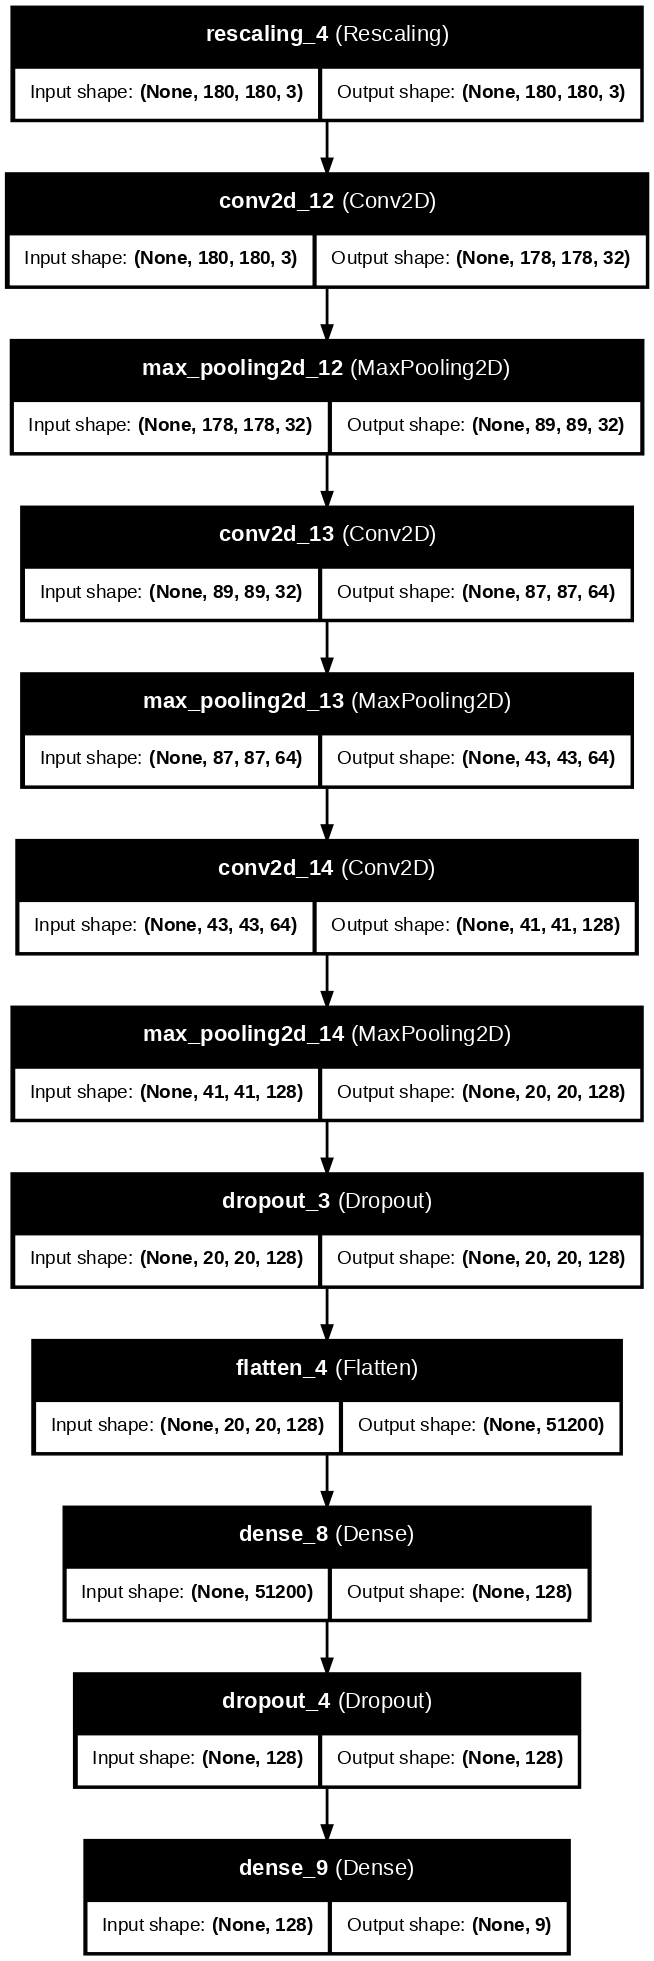

In [62]:
# Plot the Model Architecture
plot_model(
    model,
    to_file='model_augmentor_witoutbn.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=100
)

### Train Model

In [63]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs = epochs,
  callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1757 - loss: 2.1784
Epoch 1: val_accuracy improved from -inf to 0.42254, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.1760 - loss: 2.1772 - val_accuracy: 0.4225 - val_loss: 1.6375
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3836 - loss: 1.6439
Epoch 2: val_accuracy improved from 0.42254 to 0.42921, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3837 - loss: 1.6436 - val_accuracy: 0.4292 - val_loss: 1.4574
Epoch 3/50
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4549 - loss: 1.4485
Epoch 3: val_accuracy improved from 0.42921 to 0.49073, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.4550 - loss: 1.4483 - val_accuracy: 0.4907 - val_loss: 1.3203
Epoch 4/50
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4919 - loss: 1.3460
Epoch 4: val_accuracy improved 

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(early_stopping.stopped_epoch + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
model.save("/content/gdrive/My Drive/Colab Notebooks/Melanoma/best_model.keras")

### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

# Performance Analysis (Improved Results)

## 1. Observations from Training and Validation Metrics:
- **Training Accuracy**:
  - Reaches around **90.63%**, showing that the model has effectively learned patterns in the training data.
- **Validation Accuracy**:
  - Improved to around **86.65%**, a significant enhancement compared to earlier results.
  - Indicates much better generalization to unseen data, thanks to the applied strategies.
- **Training Loss**:
  - Decreased steadily to around **0.24**, reflecting consistent error minimization.
- **Validation Loss**:
  - Stabilized between **0.53 - 0.70**, showing the model is effectively generalizing without significant overfitting.

---

## 2. Analysis of Best Epoch and Early Stopping:
- **Best Epoch**:
  - The model achieved its highest validation accuracy (**86.65%**) at **epoch 36**.
  - Best model weights were saved, ensuring optimal performance on validation data.
- **Early Stopping**:
  - Activated at **epoch 46**, preventing overfitting and restoring the best weights from **epoch 36**.

---

## 3. Key Improvements:
- **Data Augmentation**:
  - The use of augmentation significantly enhanced generalization, making the model more robust to unseen data variations.
- **Class Imbalance Handling**:
  - Addressing class imbalance ensured that underrepresented classes contributed equally, improving overall accuracy and fairness in predictions.
- **Validation Metrics**:
  - Validation accuracy and loss trends now align more closely with training metrics, demonstrating better model convergence and reduced overfitting.

---

## 4. Performance Insights:
- The **validation accuracy** improvement from earlier results reflects the effectiveness of the applied techniques.
- **Stability**:
  - The reduced fluctuation in validation accuracy and loss highlights the model's increased robustness.
- **Generalization**:
  - The close alignment of training and validation performance indicates a well-balanced model capable of handling unseen data effectively.

---

## 5. Batch Normalization:
- The addition of **batch normalization** failed to enhance both training and validation accuracy significantly.
- While it stabilized the training process, the model exhibited **overfitting**, with training accuracy improving disproportionately compared to validation accuracy.

---

## 6. Conclusion:
With the applied **data augmentation** and **class imbalance handling**, the model has demonstrated significant improvements. Achieving a validation accuracy of **86.65%** and a stable loss profile, this result is much better compared to previous iterations and is well-suited for deployment in real-world applications.


## Model Prediction

In [66]:
# Import required libraries
from tensorflow.keras.preprocessing.image import load_img

# Step 1: Focus only on the "melanoma" class
melanoma_class_name = "melanoma"
melanoma_class_index = class_names.index(melanoma_class_name)  # Find the index of melanoma

# Step 2: Construct the path for melanoma test images
melanoma_image_path = os.path.join(data_dir_test, melanoma_class_name, '*')

# Step 3: Get a list of all melanoma test images
melanoma_test_images = glob(melanoma_image_path)

# Step 4: Load a random melanoma image from the list
random_image_index = 2  # Change the index to test different images
test_image = load_img(melanoma_test_images[random_image_index], target_size=(180, 180, 3))

# Step 5: Display the test image
plt.figure(figsize=(5, 5))
plt.imshow(test_image)
plt.axis('off')
plt.title("Melanoma Test Image")
plt.show()

#test_image = load_img(image_path, target_size=(180, 180))  # Resize image to model input size
img_array = img_to_array(test_image)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]


# Step 7: Make predictions using the trained model
predictions = model.predict(img_array)  # Predict probabilities for each class

# Step 8: Get the predicted class with the highest probability
predicted_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_index]

# Step 9: Print the actual and predicted class names
print(f"Actual Class: {melanoma_class_name}")  # The melanoma class
print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Actual Class: melanoma
Predicted Class: melanoma


### Predicting Melanoma Test directory

In [70]:
# Step 1: Focus only on the "melanoma" class
melanoma_class_name = "melanoma"
melanoma_class_index = class_names.index(melanoma_class_name)  # Find the index of melanoma

# Step 2: Construct the path for melanoma test images
melanoma_image_path = os.path.join(data_dir_test, melanoma_class_name, '*')

# Step 3: Get a list of all melanoma test images
melanoma_test_images = glob(melanoma_image_path)
# Loop through each image in the melanoma folder
for i, image_path in enumerate(melanoma_test_images):
    # Load and preprocess the image
    test_image = load_img(image_path, target_size=(180, 180))  # Resize image to model input size
    img_array = img_to_array(test_image)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Make prediction
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)  # Get the predicted class index
    predicted_class_name = class_names[predicted_index]  # Get the predicted class name

    # Display the image with actual and predicted labels
    print(f"Actual Class: {melanoma_class_name}")  # The melanoma class
    print(f"Predicted Class: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actua